In [4]:
import pandas as pd
from Bio.PDB import *
import os
import numpy as np
import collections

from scipy.spatial import distance
from pygsp import graphs, features
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from imblearn.under_sampling import NearMiss


from Bio import BiopythonWarning
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', BiopythonWarning)
    warnings.simplefilter('ignore', PDBConstructionWarning)

In [5]:
amino_lookup = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
amino_molecular_mass = {'A': 89.09404, 'R': 174.20274, 'N': 132.11904, 'D': 133.10384, 'C': 121.15404,
                        'Q': 146.14594, 'E': 147.13074, 'G': 75.06714, 'H': 155.15634, 'I': 131.17464,
                        'L': 131.17464, 'K': 146.18934, 'M': 149.20784, 'F': 165.19184, 'P': 115.13194,
                        'S': 105.09344, 'T': 119.12034, 'W': 204.22844, 'Y': 181.19124, 'V': 117.14784}
amino_hydrophobicity = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

def crawl_pdb(path):
    '''This funciton reads pdb files and stores there distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        try:
            print (pdb)
            info = dict()
            info[id] = pdb
            structure = parser.get_structure('pdb_file', path + '/' + pdb) # + '/' + pdb + '.pdb'
            coordinates = []
            labels = list()
            for model in structure:
                for chain in model:
                    for residue in chain:
                        try:
                            assert residue.get_resname() not in ['HOH', ' CA']
                            coordinates.append(residue['CA'].get_coord())
                            labels.append(residue.get_resname())

                        except :
                            break
                    break  ## working on chain id A only
                break      ## Working on model id 0 only
            coords = np.asmatrix(coordinates)
            distance_matrix = distance.squareform(distance.pdist(coords))
            info['coords'] = coords
            info['distance_matrix'] = distance_matrix
            info['sequence'] = ''.join([amino_lookup[s] for s in labels])
            pdbinfo_dict[pdb] = info
        except:
            pass
    return pdbinfo_dict


def get_graph(distance_matrix, network_type, rig_cutoff=8, lin_cutoff=12):
    distance_matrix[distance_matrix >= rig_cutoff] = 0
    if network_type == 'rig-boolean':
        distance_matrix[distance_matrix > 0] = 1
    elif network_type == 'weighted-rig':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    distance_matrix[i, j] = abs(j - i)
    elif network_type == 'weighted-lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = abs(i - j)
                    else:
                        distance_matrix[i, j] = 0
    elif network_type == 'lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = 1
                    else:
                        distance_matrix[i, j] = 0
    else:
        print('Invalid Choice! ' + network_type)
        return None
    G = graphs.Graph(distance_matrix, lap_type='normalized')
    G.compute_fourier_basis()
    return G


def get_signal(G, seq, signal):
    if signal == 'molecular_weight':
        s = np.asarray([amino_molecular_mass[aa] for aa in seq])
    elif signal == 'hydrophobicity':
        s = np.asarray([amino_hydrophobicity[aa] for aa in seq])
    elif signal == 'node_degree':
        s = G.d
    elif signal == 'node_weighted_degree':
        adj = G.W.todense()
        s = np.ravel(adj.sum(axis=0)) / 2
    elif signal == 'avg_adj_degree':
        s = features.compute_avg_adj_deg(G)
        s = np.ravel(s)
    elif signal == 'clustering_coeff':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = nx.clustering(N)
        s = np.asarray(list(s.values()))
    elif signal == 'aaalpha_helix':
        s = eng.aaalpha_helixfasman(seq)
        s = np.array(s._data)
    elif signal == 'residue_count':
        residue_counts = collections.Counter(seq)
        s = np.asarray([residue_counts[s] for s in seq])
    elif signal == 'centrality':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = list(nx.betweenness_centrality(N).values())
        s = np.array(s)
    elif signal == 'page_rank':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = list(nx.algorithms.link_analysis.pagerank(N).values())
        s = np.array(s)
    else:
        print ('Invalid Choice! ' + signal)
    return s


def get_filtered_signal(G, signal, cutoff):
    signal_hat = G.gft(signal)
    signal_filtered_hat = np.zeros_like(signal_hat)
    signal_filtered_hat[G.e < G.lmax * cutoff] = signal_hat[G.e < G.lmax * cutoff]
    signal_filtered = G.igft(signal_filtered_hat)
    return signal_filtered

In [6]:
pdbinfo_dict_trans = crawl_pdb('../data/transmembrane/')
pdbinfo_dict_glob = crawl_pdb('../data/globular/')

1irk.pdb
1ivo.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9662.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9760.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9802.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9837.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9869.
  warnings.warn(
/Users/dsrivast/opt/

1lz0.pdb
1lzi.pdb
1nct.pdb
1ncu.pdb
1r7t.pdb
1r7u.pdb
1r7v.pdb
1r7x.pdb
1r7y.pdb
1r80.pdb
1r81.pdb
1r82.pdb
2eb2.pdb
2eb3.pdb
2gsf.pdb
2itn.pdb
2ito.pdb
2itp.pdb
2itq.pdb
2itt.pdb
2itu.pdb
2itv.pdb
2itw.pdb
2itx.pdb
2ity.pdb
2itz.pdb
2ivs.pdb
2j5f.pdb
2j6m.pdb
2jiu.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5023.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5054.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5085.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5232.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5386.
  warnings.warn(
/Users/dsrivast/opt/

2jiv.pdb
2jwa.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5099.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5139.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5181.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5224.
  warnings.warn(


2k1k.pdb
2k1l.pdb
2k3g.pdb
2k9y.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 20367.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 20376.
  warnings.warn(


2ks1.pdb
2kso.pdb
2l2t.pdb
2l6w.pdb
2l9u.pdb
2lcx.pdb
2lzl.pdb
2m0b.pdb
2m20.pdb
2m59.pdb
2met.pdb
2meu.pdb
2mfr.pdb
2n2a.pdb
2n5s.pdb
2n90.pdb
2qj9.pdb
2qja.pdb
2qjb.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3727.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3779.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3831.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3890.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3750.
  warnings.warn(
/Users/dsrivast/opt/

2qkq.pdb
2qlu.pdb
2qo2.pdb
2qo9.pdb
2qoc.pdb
2qod.pdb
2qof.pdb
2qoi.pdb
2qok.pdb
2qol.pdb
2qoo.pdb
2qu5.pdb
2qu6.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4913.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4954.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4990.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5166.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5222.
  warnings.warn(
/Users/dsrivast/opt/

2r2p.pdb
2r4b.pdb
2rei.pdb
2rf9.pdb
2rfd.pdb
2rfe.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5411.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9787.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9799.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9806.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9815.
  warnings.warn(
/Users/dsrivast/opt/

2rfn.pdb
2rfs.pdb
2rgp.pdb
2rit.pdb
2rix.pdb
2riy.pdb
2riz.pdb
2rj0.pdb
2rj1.pdb
2rj4.pdb
2rj5.pdb
2rj6.pdb
2rj7.pdb
2rj8.pdb
2rj9.pdb
2rl5.pdb
2uzx.pdb
2v62.pdb
2vwu.pdb
2vwv.pdb
2vww.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5707.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5724.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5728.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5897.
  warnings.warn(


2vwx.pdb
2vwy.pdb
2vwz.pdb
2vx0.pdb
2vx1.pdb
2wot.pdb
2x1w.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 19385.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 19463.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 19542.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 19621.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 19699.
  warnings.warn(
/Users/dsrivast

2x2u.pdb
2x4u.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14438.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14468.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14486.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14528.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14558.
  warnings.warn(
/Users/dsrivast

2x9f.pdb
2xir.pdb
2yn8.pdb
2zm3.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10309.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10336.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10363.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10390.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10417.
  warnings.warn(
/Users/dsrivast

3a7e.pdb
3b2t.pdb
3b2v.pdb
3b71.pdb
3b8q.pdb
3b8r.pdb
3bbt.pdb
3bbw.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5051.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5086.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5121.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5170.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5014.
  warnings.warn(
/Users/dsrivast/opt/

3bce.pdb
3bd9.pdb
3be1.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7715.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7716.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7736.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7802.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7872.
  warnings.warn(
/Users/dsrivast/opt/

3be2.pdb
3bea.pdb
3bel.pdb
3bgm.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3641.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3653.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3657.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3932.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4040.
  warnings.warn(
/Users/dsrivast/opt/

3bpr.pdb
3brb.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9442.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9478.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9509.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9623.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2866.
  warnings.warn(
/Users/dsrivast/opt/

3bu3.pdb
3bu5.pdb
3bu6.pdb
3buo.pdb
3bux.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5678.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5687.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6004.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6017.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5164.
  warnings.warn(
/Users/dsrivast/opt/

3bwm.pdb
3c1x.pdb
3c4f.pdb
3c7q.pdb
3c8x.pdb
3caf.pdb
3ccn.pdb
3cd8.pdb
3ce3.pdb
3cjf.pdb
3cjg.pdb
3ckh.pdb
3cly.pdb
3cp9.pdb
3cpb.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3176.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3258.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5007.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5037.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5067.
  warnings.warn(
/Users/dsrivast/opt/

3cpc.pdb
3cth.pdb
3ctj.pdb
3cu0.pdb
3cu1.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4406.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4461.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4516.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4596.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4664.
  warnings.warn(
/Users/dsrivast/opt/

3czu.pdb
3d94.pdb
3dar.pdb
3dkc.pdb
3dkf.pdb
3dkg.pdb
3dko.pdb
3dpk.pdb
3dzq.pdb
3efj.pdb
3efk.pdb
3ekk.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4883.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4920.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4957.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4998.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4858.
  warnings.warn(
/Users/dsrivast/opt/

3ekn.pdb
3eta.pdb
3eu9.pdb
3euu.pdb
3f66.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5368.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5408.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5448.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5561.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5883.
  warnings.warn(
/Users/dsrivast/opt/

3f7p.pdb
3f7q.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10964.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10996.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11021.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11275.
  warnings.warn(


3f7r.pdb
3f82.pdb
3faa.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13965.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14007.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14049.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14081.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14123.
  warnings.warn(


3fl7.pdb
3fq4.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6156.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6317.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6614.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6756.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2963.
  warnings.warn(
/Users/dsrivast/opt/

3fso.pdb
3fxx.pdb
3fy2.pdb
3g0e.pdb
3g0f.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5228.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5255.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5277.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5285.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4764.
  warnings.warn(
/Users/dsrivast/opt/

3gop.pdb
3gqi.pdb
3gql.pdb
3gxl.pdb
3gxu.pdb
3h3b.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2951.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3122.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7624.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7692.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7740.
  warnings.warn(
/Users/dsrivast/opt/

3h6a.pdb
3h7b.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7128.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7152.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7158.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7170.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7176.
  warnings.warn(
/Users/dsrivast/opt/

3h8k.pdb
3h8m.pdb
3h9h.pdb
3h9r.pdb
3h9s.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7464.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7482.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7488.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7494.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7500.
  warnings.warn(
/Users/dsrivast/opt/

3hei.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21724.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21924.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22150.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22375.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22546.
  warnings.warn(
/Users/dsrivast

3hil.pdb
3hmm.pdb
3hng.pdb
3hpn.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9323.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9499.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9689.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9858.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10028.
  warnings.warn(
/Users/dsrivast/opt

3i5n.pdb
3i81.pdb
3ika.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5451.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5557.
  warnings.warn(


3ioh.pdb
3ioi.pdb
3ioj.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10590.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10637.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10674.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10926.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5163.
  warnings.warn(
/Users/dsrivast/

3js2.pdb
3kcf.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14005.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14047.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14089.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14121.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 14163.
  warnings.warn(
/Users/dsrivast

3kka.pdb
3krj.pdb
3krl.pdb
3kul.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9588.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9608.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9612.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9767.
  warnings.warn(


3kvq.pdb
3kxx.pdb
3ky2.pdb
3l8v.pdb
3l9p.pdb
3lcd.pdb
3lco.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5171.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5186.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5191.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5342.
  warnings.warn(


3lcs.pdb
3lct.pdb
3lee.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 33436.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 33462.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 33488.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 33514.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 33540.
  warnings.warn(
/Users/dsrivast

3lq8.pdb
3mbw.pdb
3njp.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21386.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21498.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 21638.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21694.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21707.
  warnings.warn(
/Users/dsrivast

3p1i.pdb
3pls.pdb
3poz.pdb
3pp0.pdb
3ug1.pdb
3ug2.pdb
3v0l.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9960.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10028.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10096.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10190.
  warnings.warn(


3v0m.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10656.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10718.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10785.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11066.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10740.
  warnings.warn(
/Users/dsrivast

3v0n.pdb
3v0o.pdb
3v0p.pdb
3v0q.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10831.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10899.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10962.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11257.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11028.
  warnings.warn(
/Users/dsrivast

3vjn.pdb
3vjo.pdb
3zew.pdb
3zzw.pdb
4ag8.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4612.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4657.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4702.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4760.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9133.
  warnings.warn(
/Users/dsrivast/opt/

4agc.pdb
4agd.pdb
4aw5.pdb
4bb4.pdb
4bkf.pdb
4et7.pdb
4gt4.pdb
5eta.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9205.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9213.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9221.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9344.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11891.
  warnings.warn(
/Users/dsrivast/opt

5lv6.pdb
1d9i.pdb
1dp7.pdb
1e1g.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2893.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 3022.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1341.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 1390.
  warnings.warn(


1e1j.pdb
1e1p.pdb
1e1s.pdb
1e1u.pdb
1e1w.pdb
1hjm.pdb
1hjn.pdb
1ifr.pdb
1ivt.pdb
1jlj.pdb
1pk6.pdb
1yzb.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4545.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4546.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4549.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4812.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5045.
  warnings.warn(
/Users/dsrivast/opt/

2hqw.pdb
2i6k.pdb
2jg8.pdb
2jg9.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1782.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1851.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4379.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4406.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4425.
  warnings.warn(
/Users/dsrivast/opt/

2jhh.pdb
2jhi.pdb
2jhk.pdb
2jhl.pdb
2jhm.pdb
2ka3.pdb
2kb0.pdb
2lll.pdb
2lso.pdb
2oii.pdb
2pe9.pdb
2pea.pdb
2w3c.pdb
2wnu.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6978.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 6993.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7028.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7059.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7078.
  warnings.warn(
/Users/dsrivast/opt/

2wnv.pdb
3gef.pdb
3pow.pdb
3sea.pdb
3tvn.pdb
3tvo.pdb
3tyy.pdb
4cay.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3246.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3275.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3312.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3441.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2887.
  warnings.warn(
/Users/dsrivast/opt/

4dou.pdb
4dz7.pdb
4dz9.pdb
4f3j.pdb
4j5l.pdb
4j5m.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12828.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12882.
  warnings.warn(


4l8t.pdb
4lnz.pdb
4lwz.pdb
4lx0.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17010.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17068.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17126.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17159.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17208.
  warnings.warn(
/Users/dsrivast

4lx1.pdb
4lx2.pdb
4nn0.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7291.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7405.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7473.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7481.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7753.
  warnings.warn(
/Users/dsrivast/opt/

5dum.pdb
5dup.pdb
5dur.pdb
5fug.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 20487.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 20534.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 20582.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 20629.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 20672.
  warnings.warn(
/Users/dsrivast

5hkj.pdb
5hzf.pdb
5l1y.pdb
5lk5.pdb


/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22028.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22029.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22030.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22031.
  warnings.warn(
/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 22032.
  warnings.warn(
/Users/dsrivast

In [11]:
G_glob = {}
G_trans = {}

for pdb in pdbinfo_dict_glob.keys():
    try:
        G_glob[pdb] = get_graph(pdbinfo_dict_glob[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    except:
        continue
        
for pdb in pdbinfo_dict_trans.keys():
    try:
        G_trans[pdb] = get_graph(pdbinfo_dict_trans[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    except:
        continue

/Users/dsrivast/opt/anaconda3/envs/protein_gsp/lib/python3.9/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


In [12]:
signals = ['molecular_weight', 'hydrophobicity', 'node_degree', 'node_weighted_degree', 
           'residue_count', 'clustering_coeff', 'centrality', 'page_rank']

In [13]:
X_all

,centrality,clustering_coeff,hydrophobicity,molecular_weight,node_degree,node_weighted_degree,page_rank,residue_count


In [14]:
# for lfc_cutoff in np.arange(0.55, 0.65, 0.01):#    
    
lfc_cutoff = 0.59
model = 'weighted-rig'

gsp_features = pd.DataFrame(columns=signals + ['class'])

for pdb in G_glob.keys():
    row = []
    c = -1 ## -1 means globular
    G = G_glob[pdb]
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict_glob[pdb]['sequence'], signal=signal_name)
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        row.append(value)

    row.append(c)
    gsp_features.loc[pdb] = row


import random   
for pdb in G_trans.keys():
    row = []
    c = 1 # 1 means transmembrane
    G = G_trans[pdb]
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict_trans[pdb]['sequence'], signal=signal_name)
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*lfc_cutoff])) / np.sum(abs(signal_hat))
        row.append(value)

    row.append(c)
    gsp_features.loc[pdb] = row

X_all = gsp_features[gsp_features.columns.difference(['class'])]
y_all = gsp_features['class']

nm = NearMiss(version=1)
X, y = nm.fit_resample(X_all, y_all)

# lr = LinearRegression()
# lr.fit(X, y)
# print (lfc_cutoff, end=' : ')
# print (lr.score(X, y))

In [41]:
X.shape

(100, 8)

In [44]:
y.value_counts()

-1.0    50
 1.0    50
Name: class, dtype: int64

In [15]:
lr = LinearRegression()
lr.fit(X, y)
print (lfc_cutoff, end=' : ')
print (lr.score(X, y))

0.59 : 0.44096990037616013


In [23]:
# Logistic Regression

from sklearn.linear_model import LogisticRegressionCV
logreg = LogisticRegressionCV(cv=10, random_state=0).fit(X, y)
print (logreg.score(X, y))

0.82


In [40]:
?logreg.score

In [36]:
logreg.Cs_.shape

(10,)

In [37]:
X.shape

(100, 8)

In [68]:

logreg.scores_[1.0][:,-1]

array([0.7, 0.9, 0.6, 0.9, 1. , 0.5, 0.8, 0.8, 1. , 0.8])

In [71]:
np.mean(logreg.scores_[1.0][:,-1])

0.8

Text(0.5, 1.0, 'Transmembrane vs globular classification')

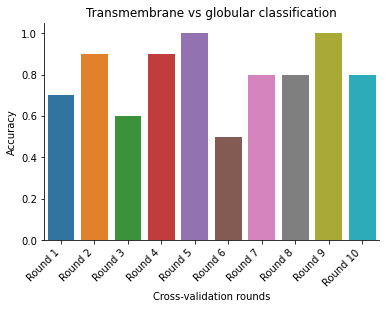

In [69]:
x = sns.barplot(x=[f'Round {i}' for i in range(1, 11)], y=logreg.scores_[1.0][:,-1])
# x.set_xticklabels(x.xticklabels, rotation = 45, ha="right")
t = plt.setp(x.get_xticklabels(), ha="right", rotation=45)
sns.despine()
x.set_xlabel('Cross-validation rounds')
x.set_ylabel('Accuracy')
x.set_title('Transmembrane vs globular classification')

<AxesSubplot:>

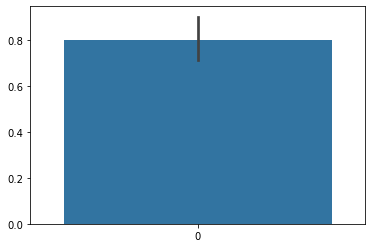

In [70]:
sns.barplot(data=logreg.scores_[1.0][:,-1], orient='v')

Text(0, 0.5, 'Classifier Cross Validation Score')

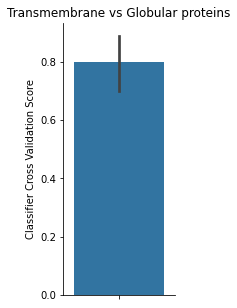

In [77]:
plt.figure(figsize=(2,5))
x = sns.barplot(data=logreg.scores_[1.0][:,-1], orient='v')
sns.despine()
x.set_title('Transmembrane vs Globular proteins')
x.set_xticklabels(labels=[''])
x.set_ylabel('Classifier Cross Validation Score')

In [ ]:
plt.figure(figsize=(2,5))
x = sns.barplot(data=fold_scores, orient='v')
sns.despine()
x.set_title('Alpha vs Beta proteins')
x.set_xlabel('')
x.set_ylabel('Lasso Cross Validation Score')

In [149]:
X.columns

Index(['centrality', 'clustering_coeff', 'hydrophobicity', 'molecular_weight',
       'node_degree', 'node_weighted_degree', 'page_rank', 'residue_count'],
      dtype='object')

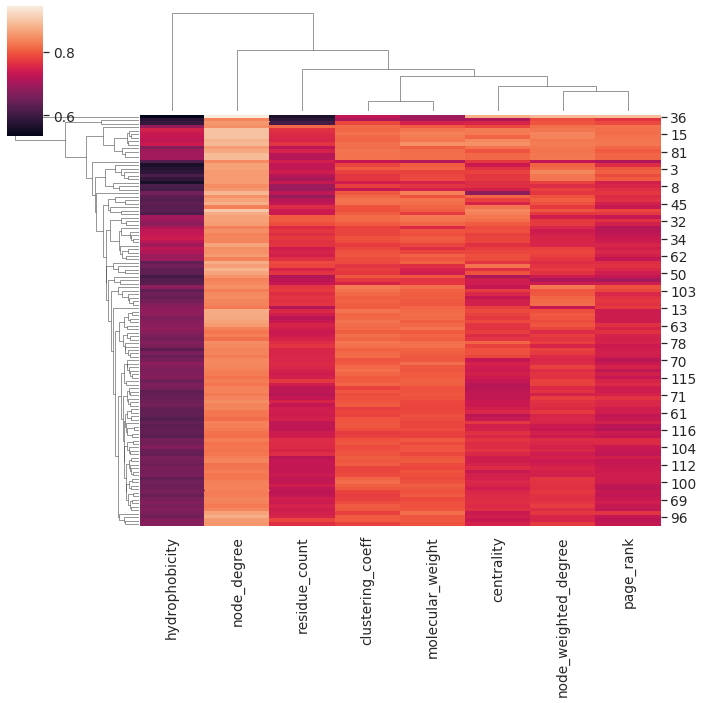

In [150]:
import seaborn as sns
sns.clustermap(X)


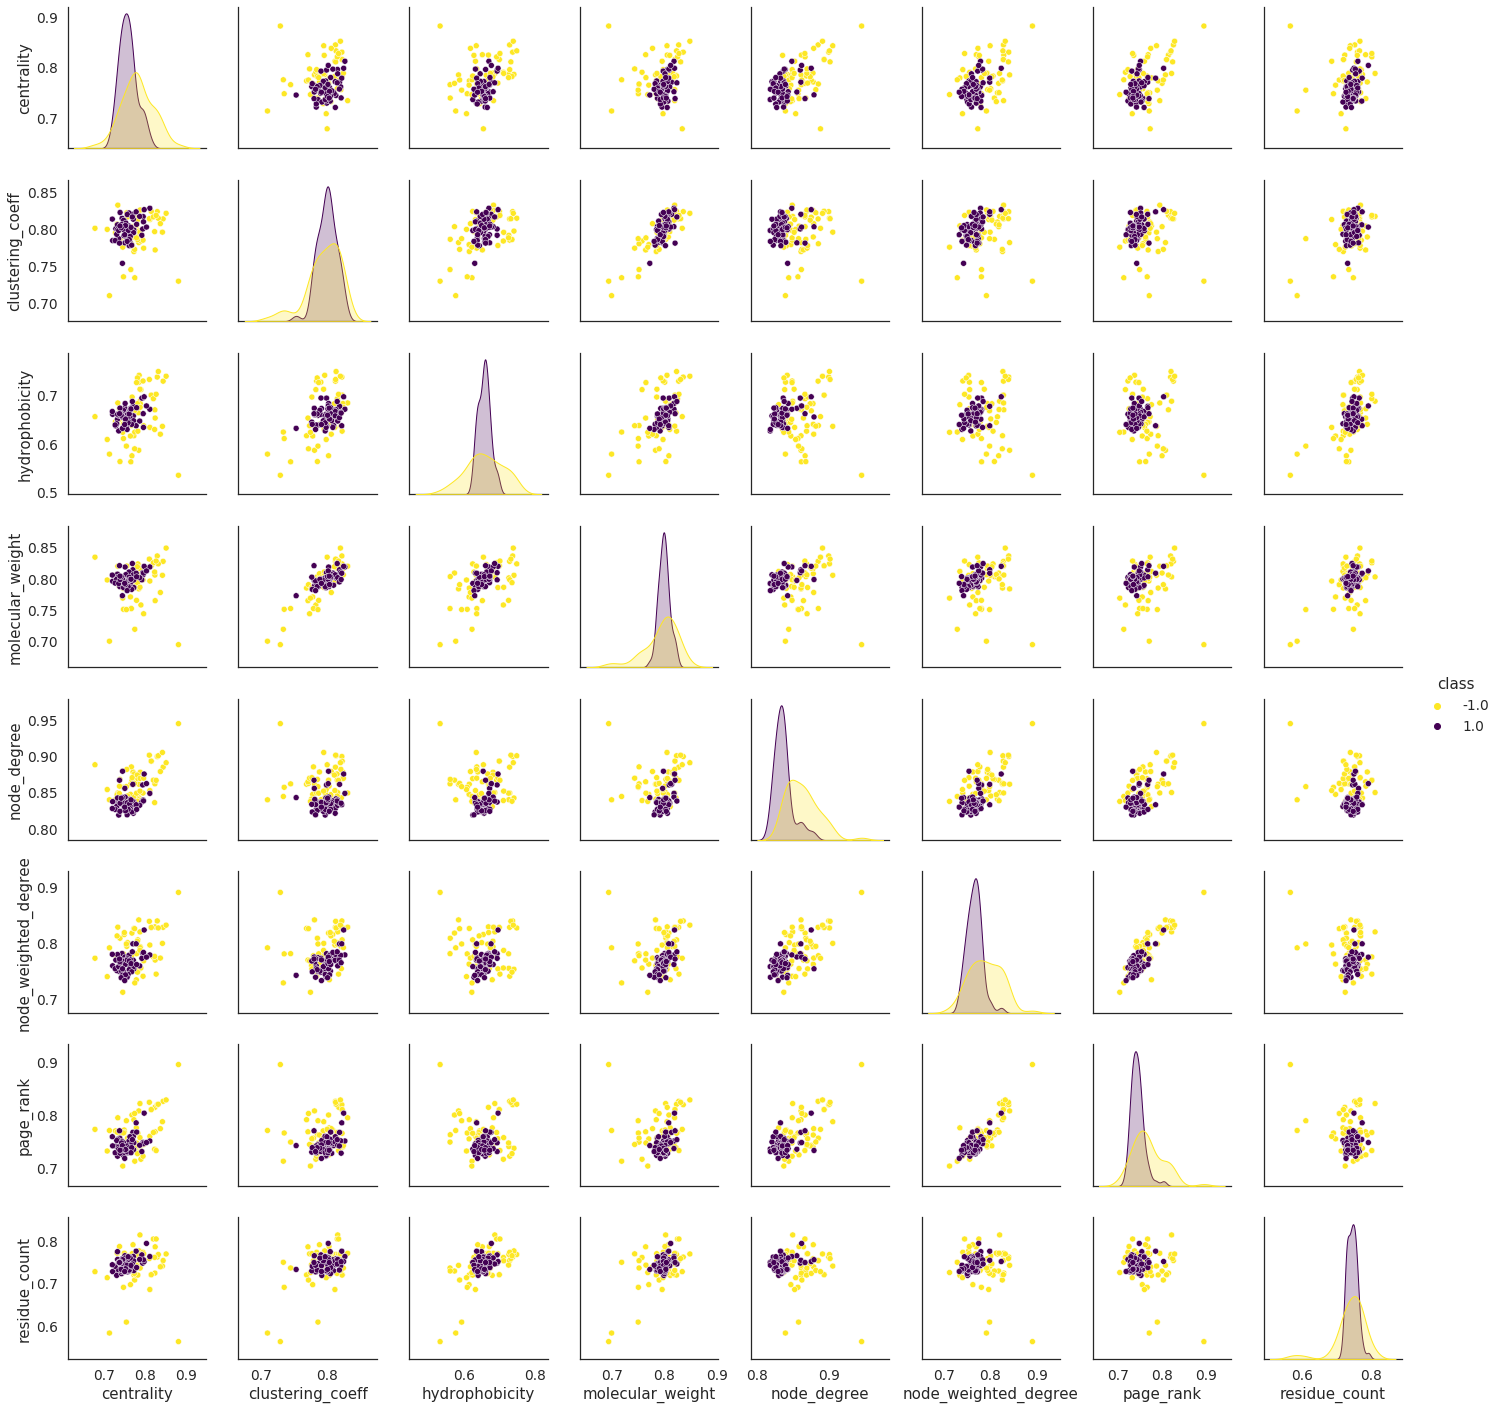

In [17]:
import seaborn as sns
sns.set(font_scale=1.25)
sns.set_style("white")
g = sns.pairplot(pd.concat([X, y], axis=1), hue='class', palette='viridis_r')
# g._legend.remove()
sns.despine()

In [103]:

lr.coef_

array([-9.83268609, -4.9736504 ,  7.87178178, -2.32692551, -3.01525181,
        1.77796227])

In [104]:
X.columns


Index(['clustering_coeff', 'hydrophobicity', 'molecular_weight', 'node_degree',
       'node_weighted_degree', 'residue_count'],
      dtype='object')

# plot

In [154]:
f1_score

<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

0.8135593220338984
0.8225806451612904


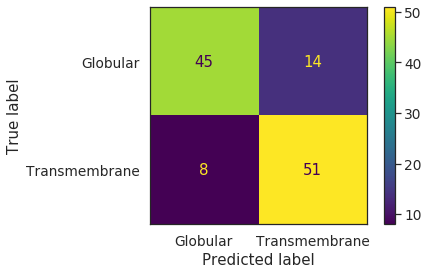

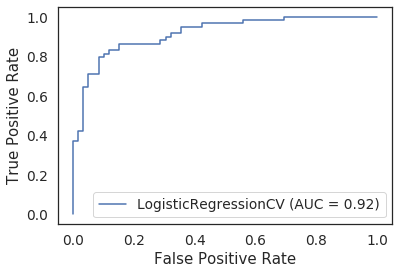

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Logistic Regression

from sklearn.linear_model import LogisticRegressionCV
logreg = LogisticRegressionCV(cv=10, random_state=0, penalty='l2').fit(X, y)
print (logreg.score(X, y))

from sklearn.metrics import plot_roc_curve, precision_recall_curve, confusion_matrix, plot_confusion_matrix, f1_score

plot_confusion_matrix(logreg, X, y, display_labels=['Globular', 'Transmembrane'])
plot_roc_curve(logreg, X, y)

print (f1_score(y, logreg.predict(X)))

In [138]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(X, y)
linreg.score(X, y)

0.1349895778436757